/tmp/ipykernel_133998/2593300134.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=order, showfliers=False, showmeans=True,


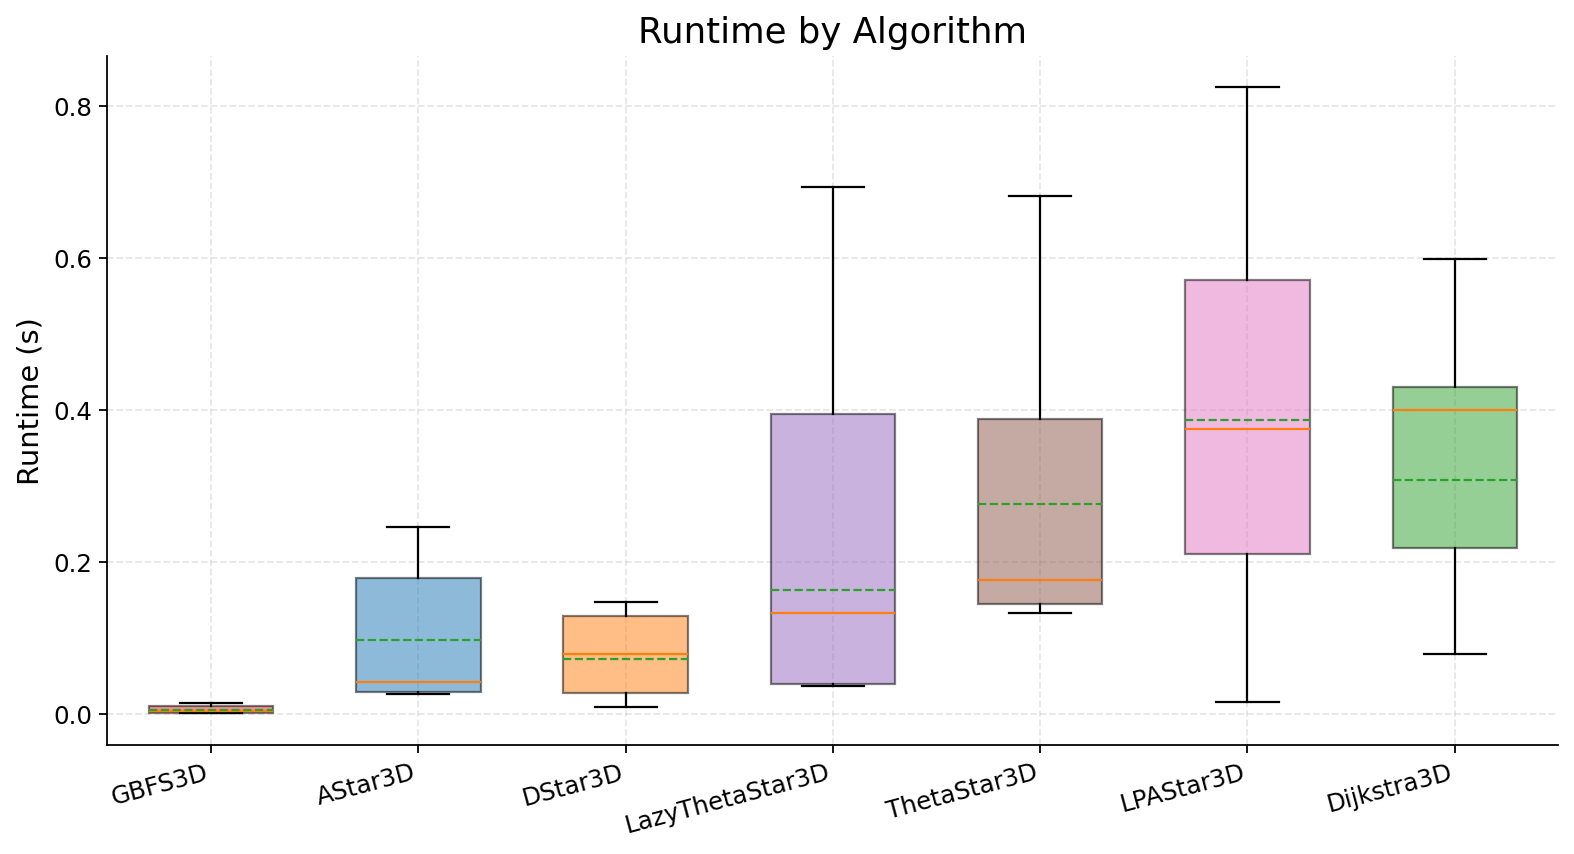

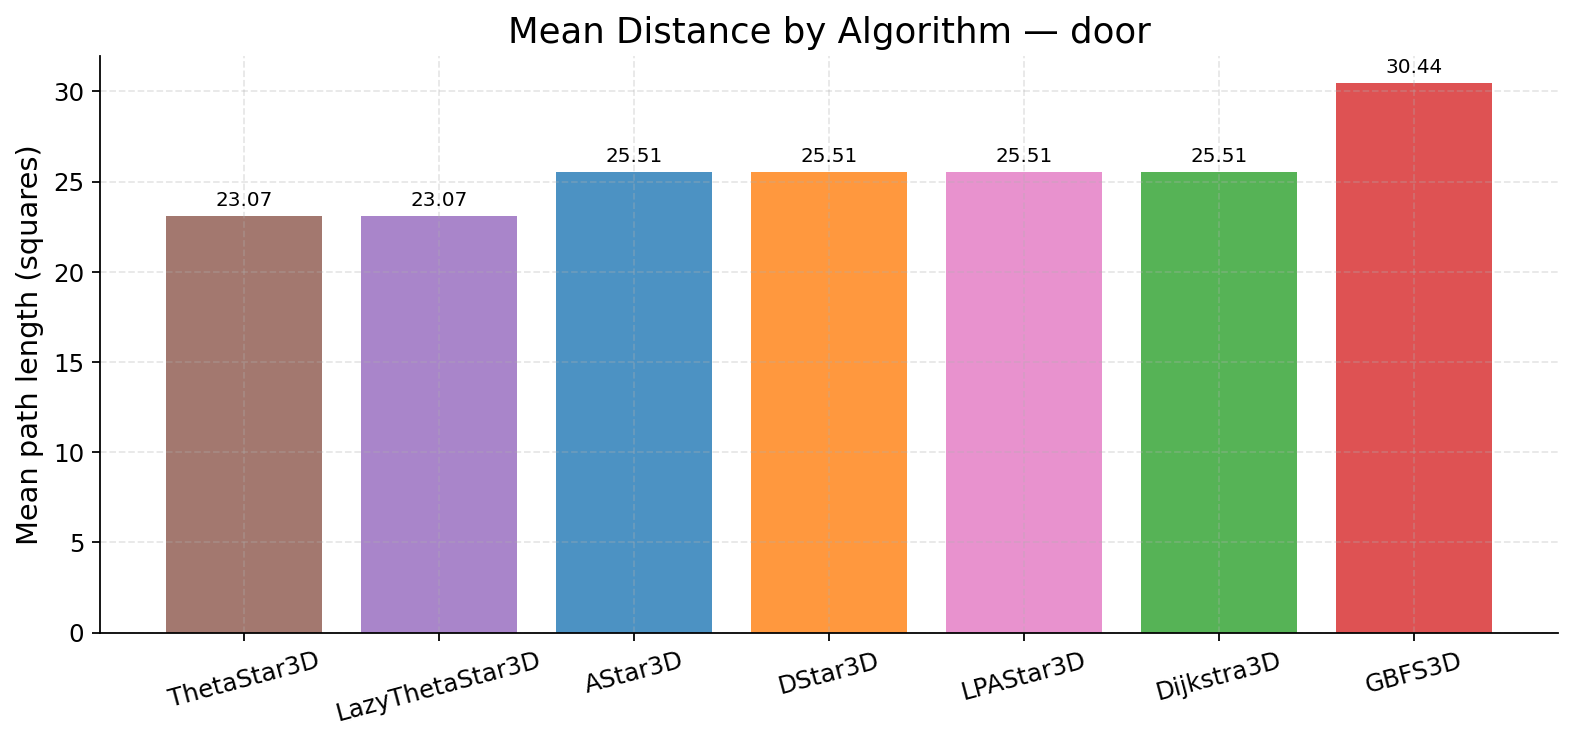

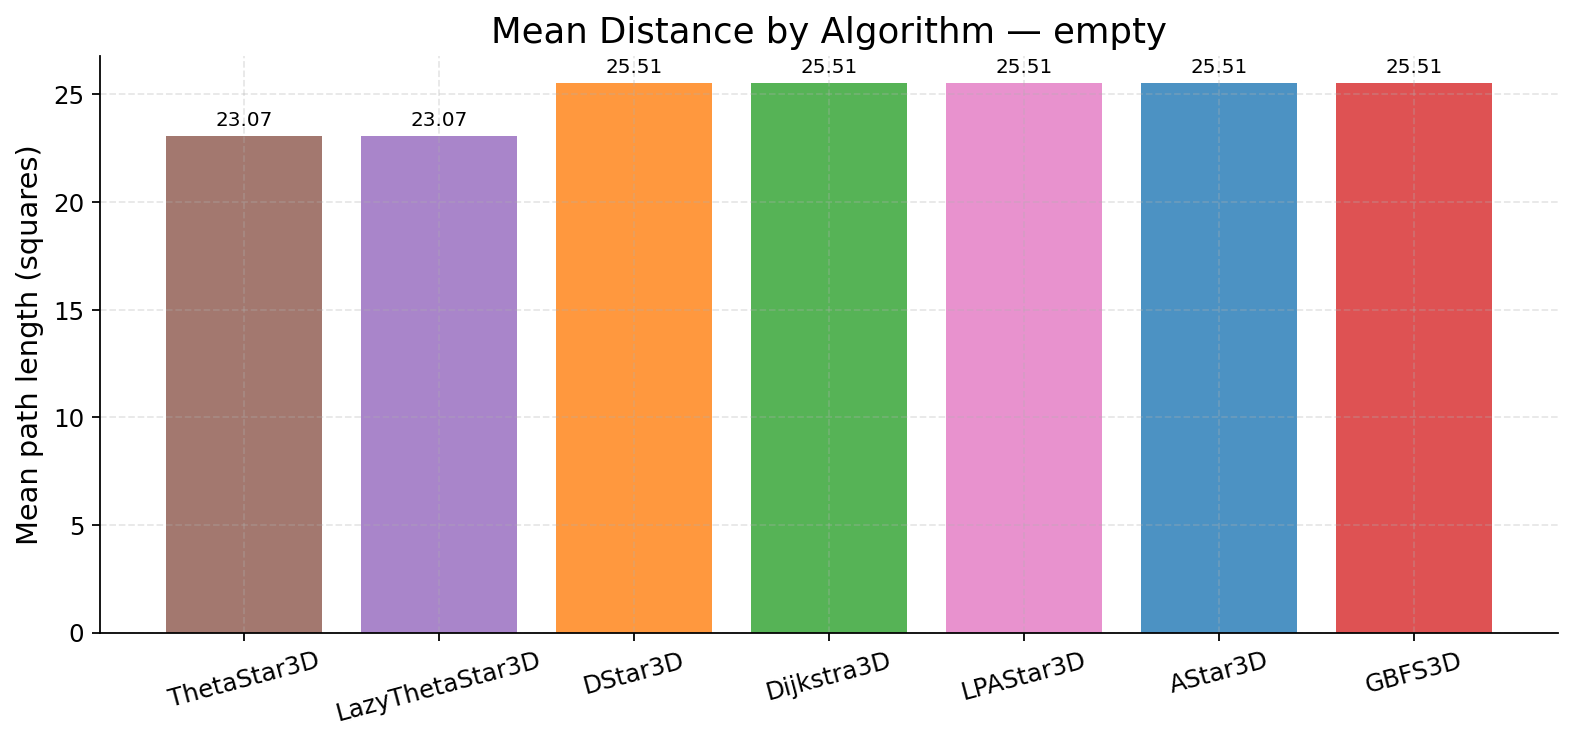

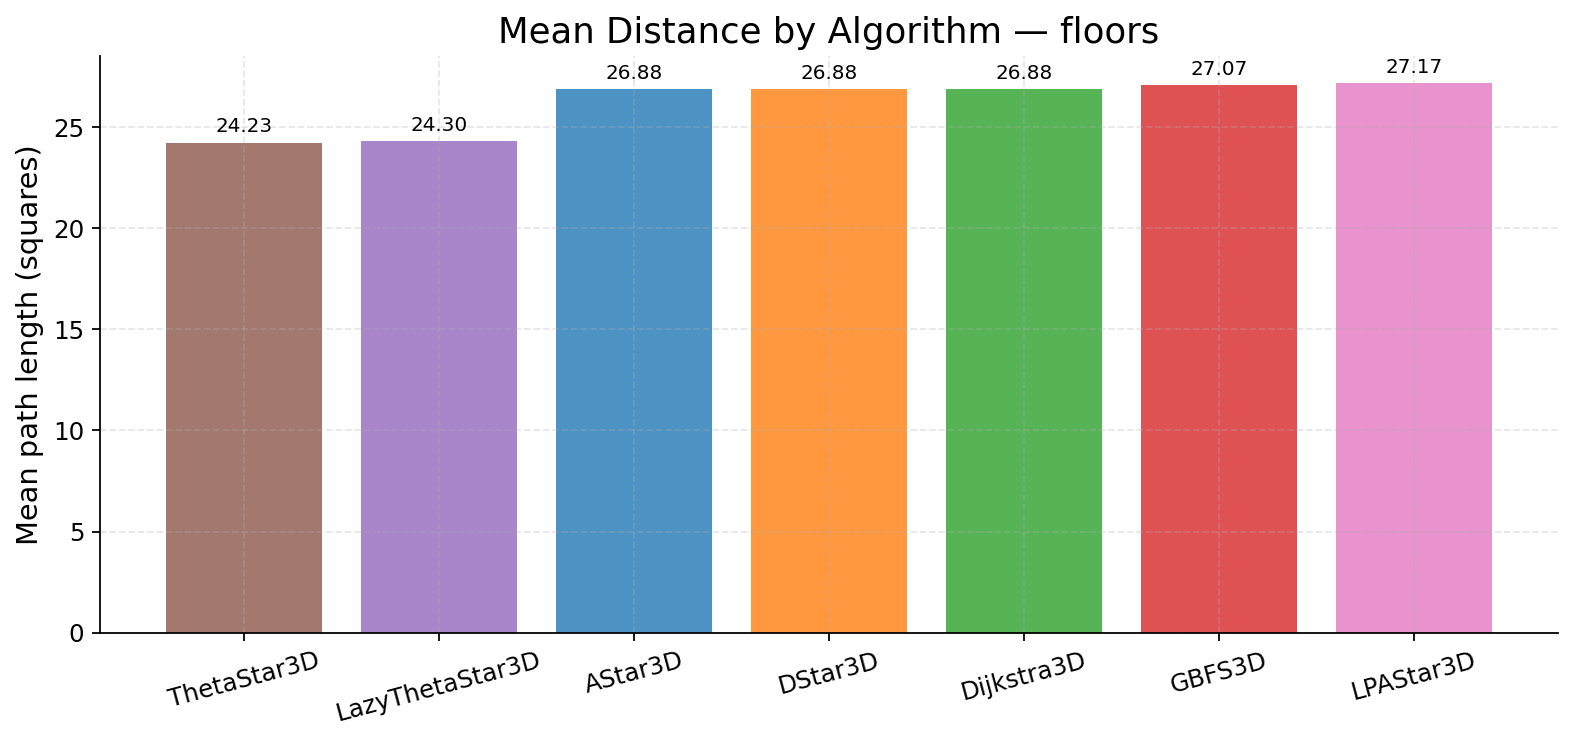

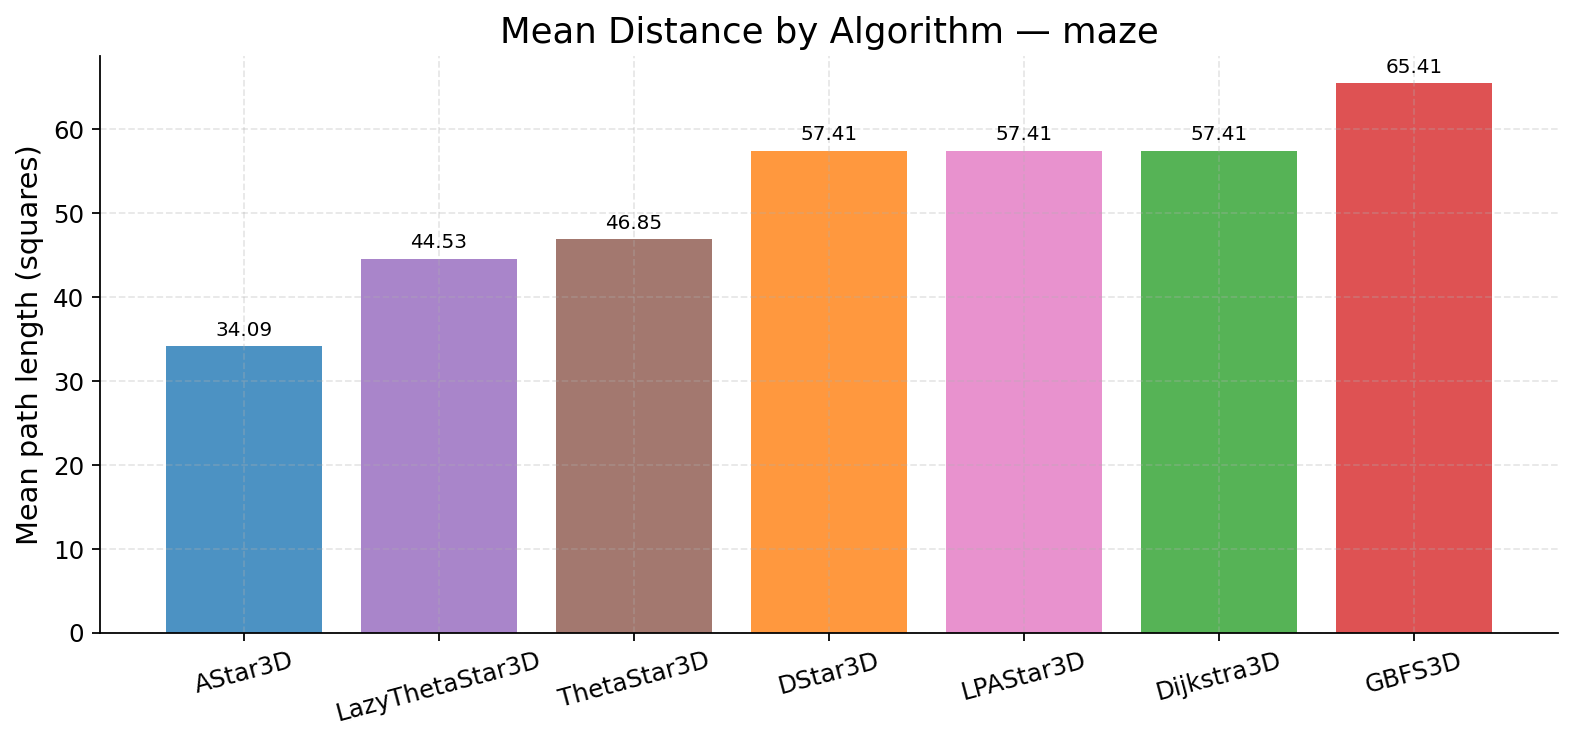

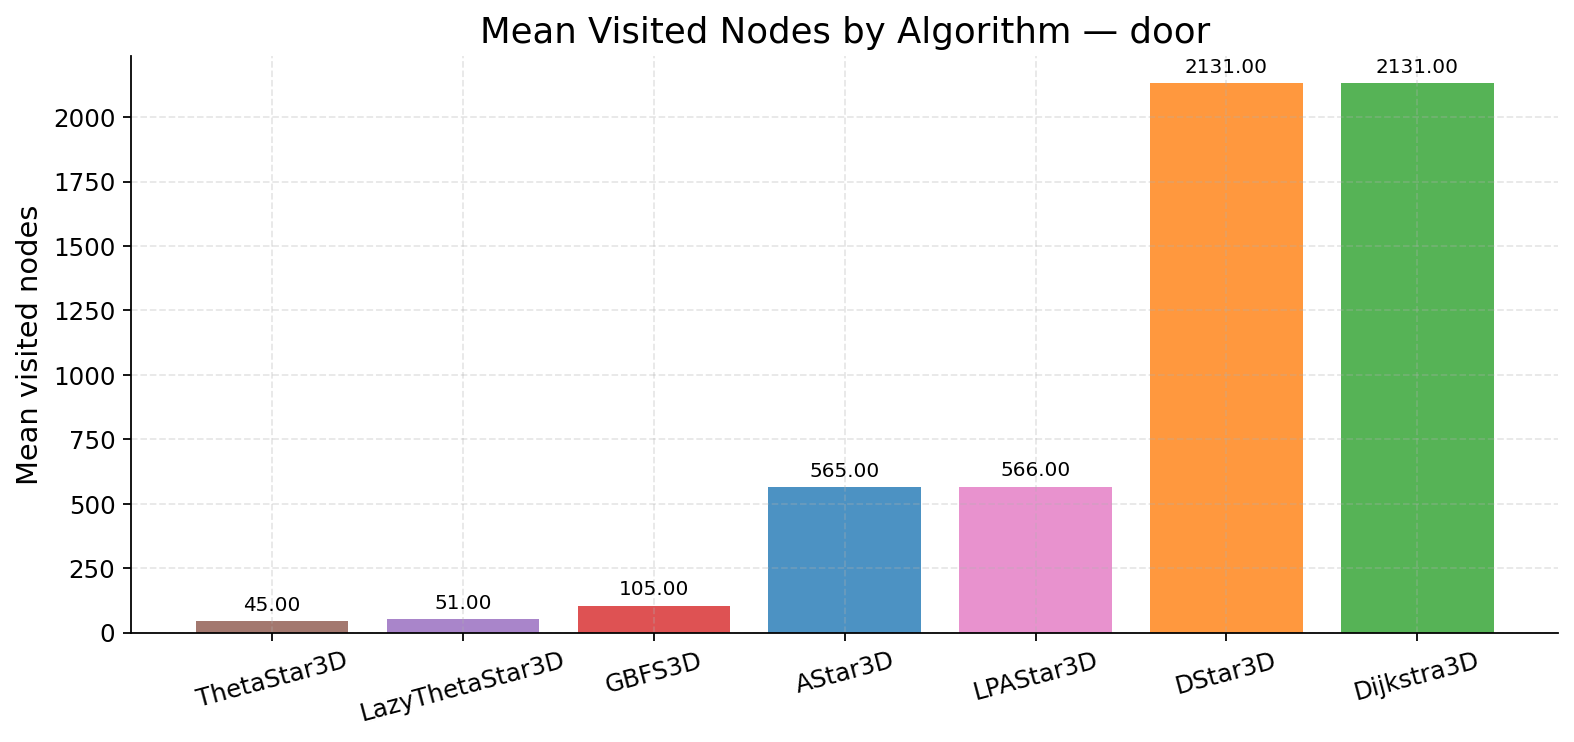

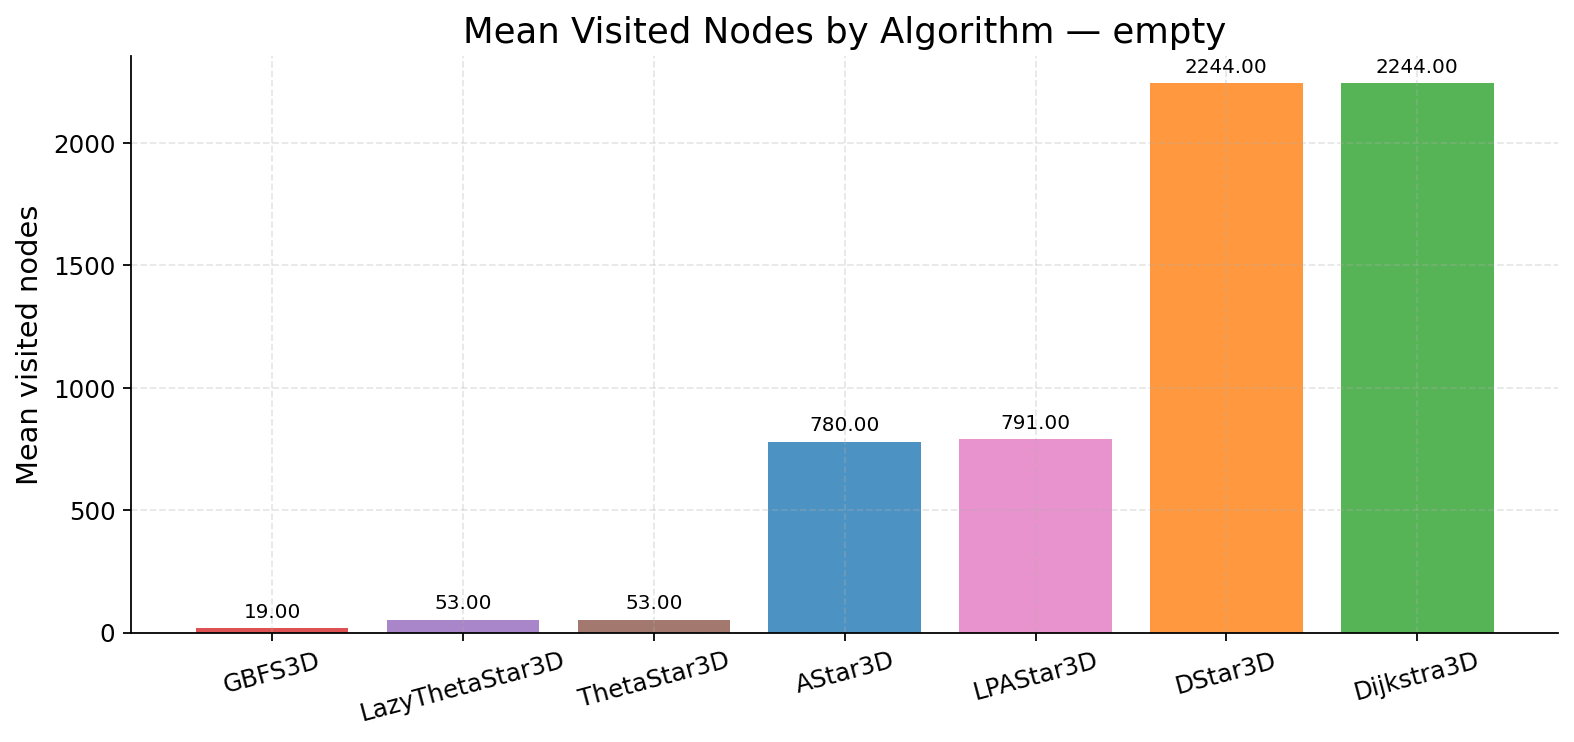

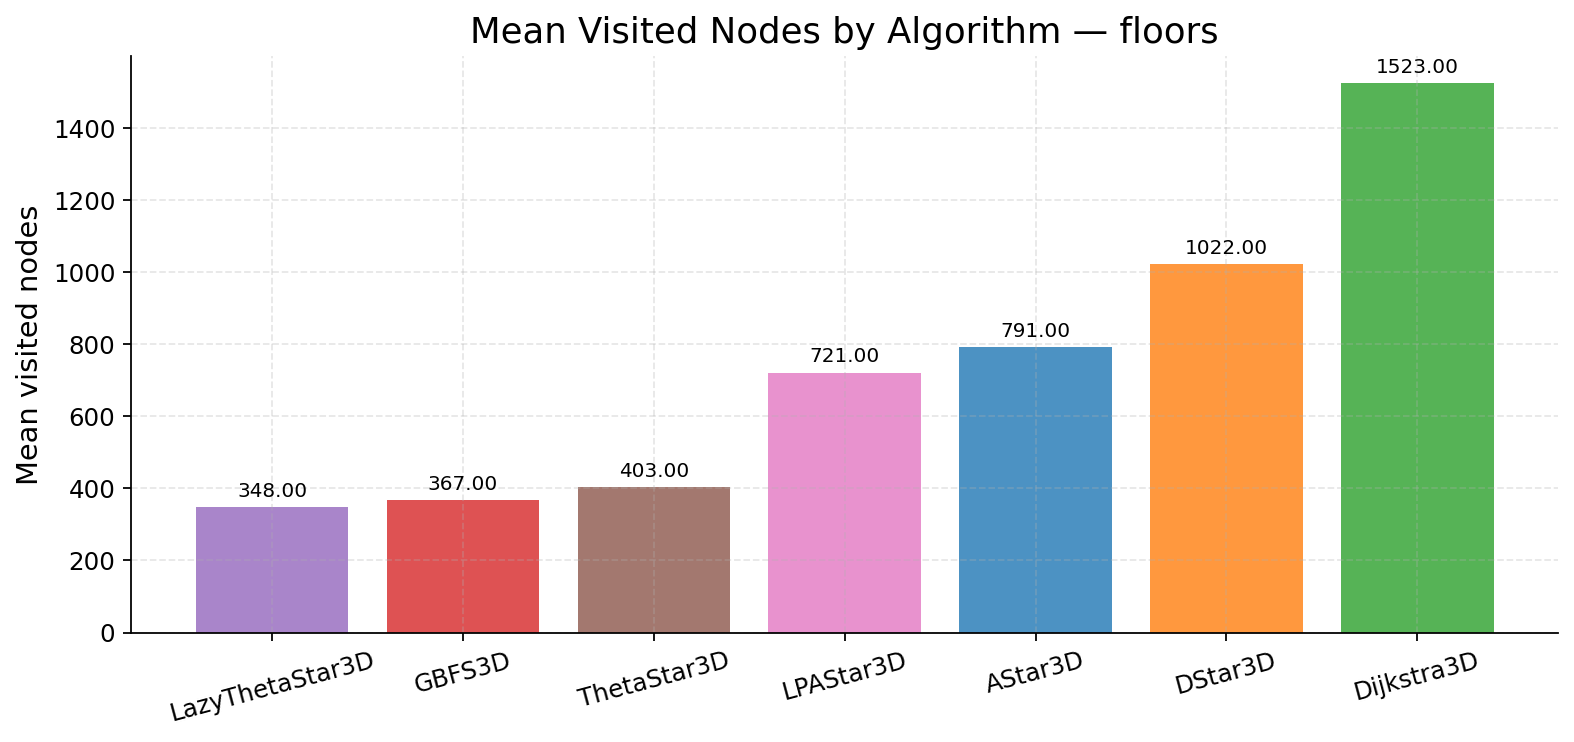

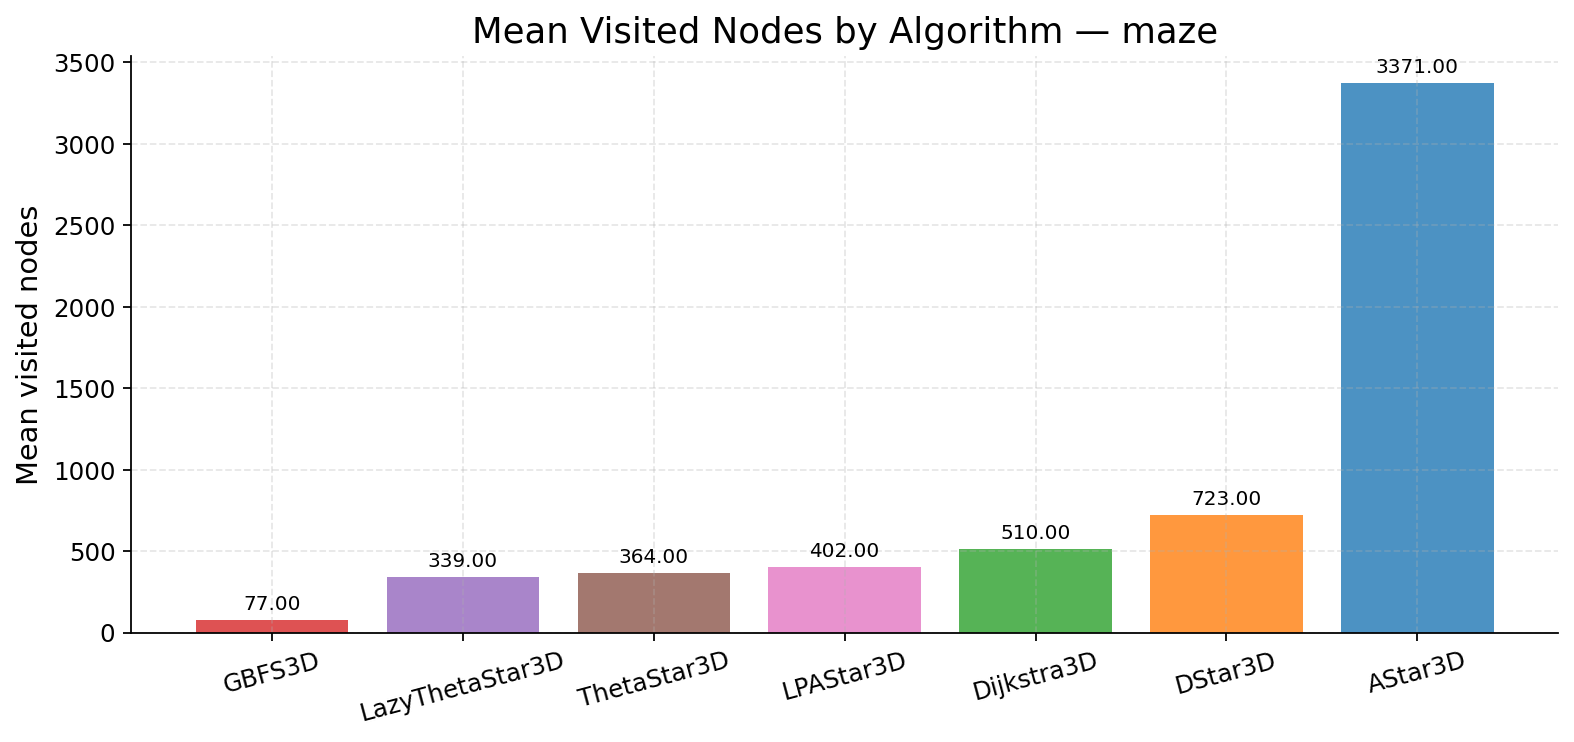

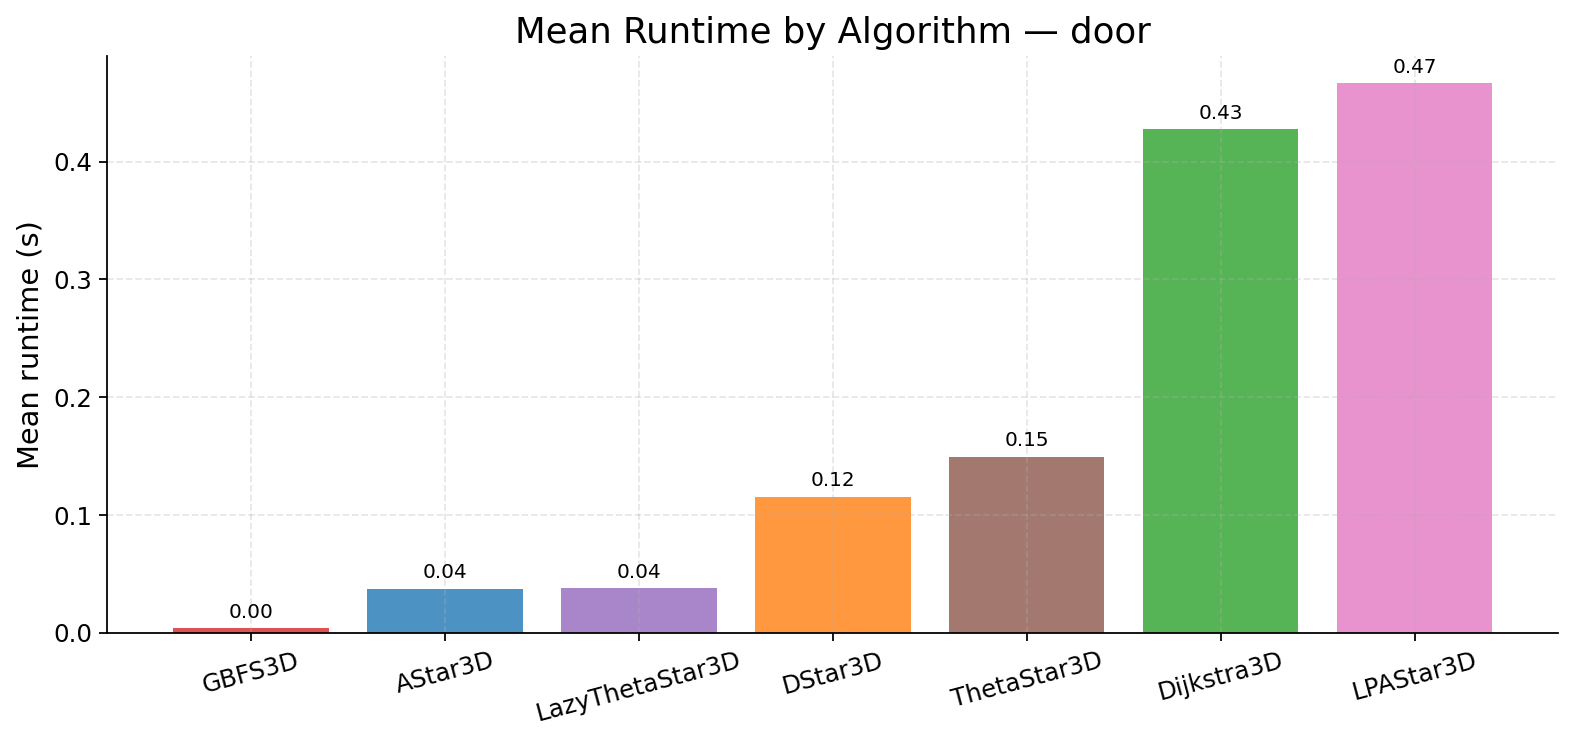

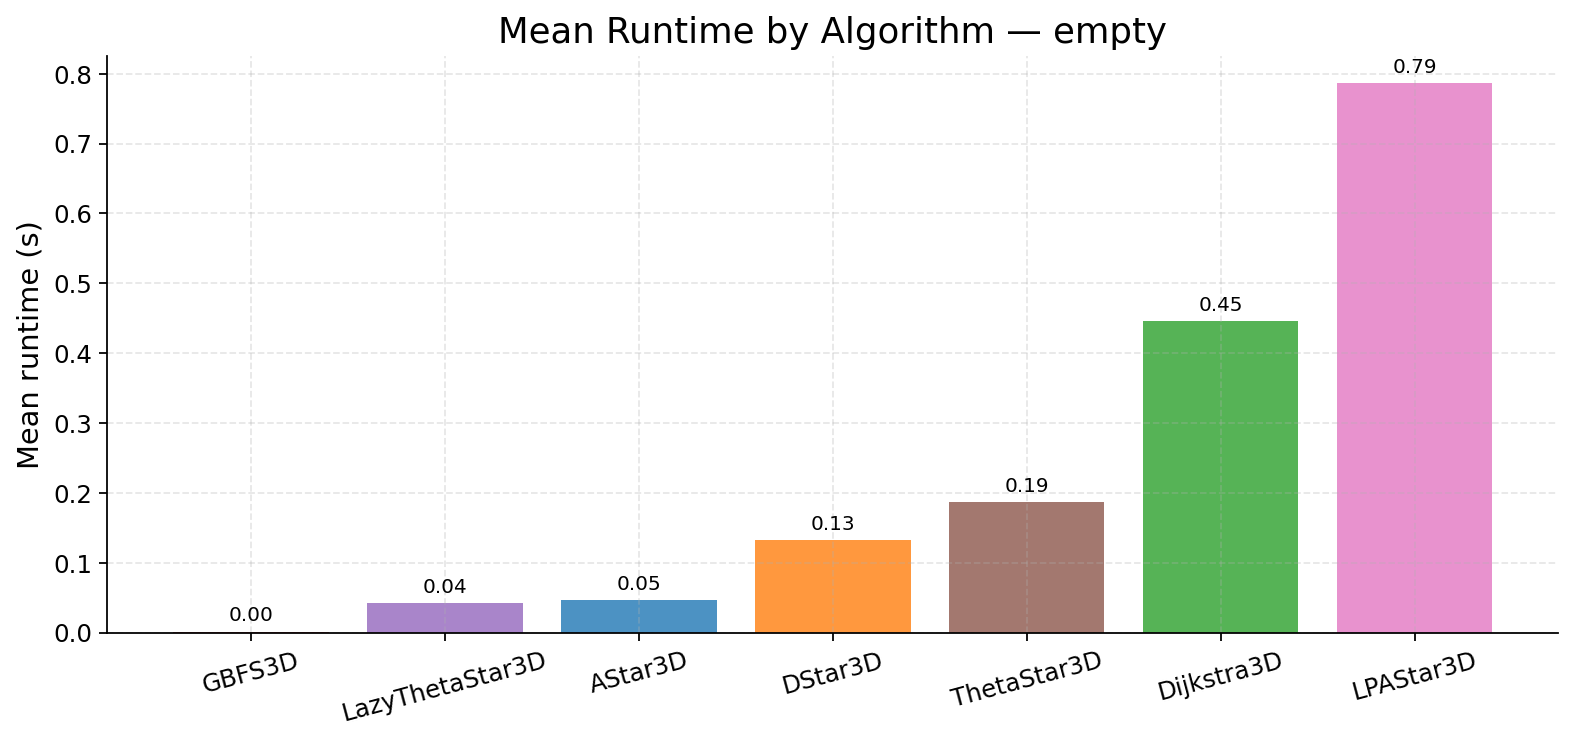

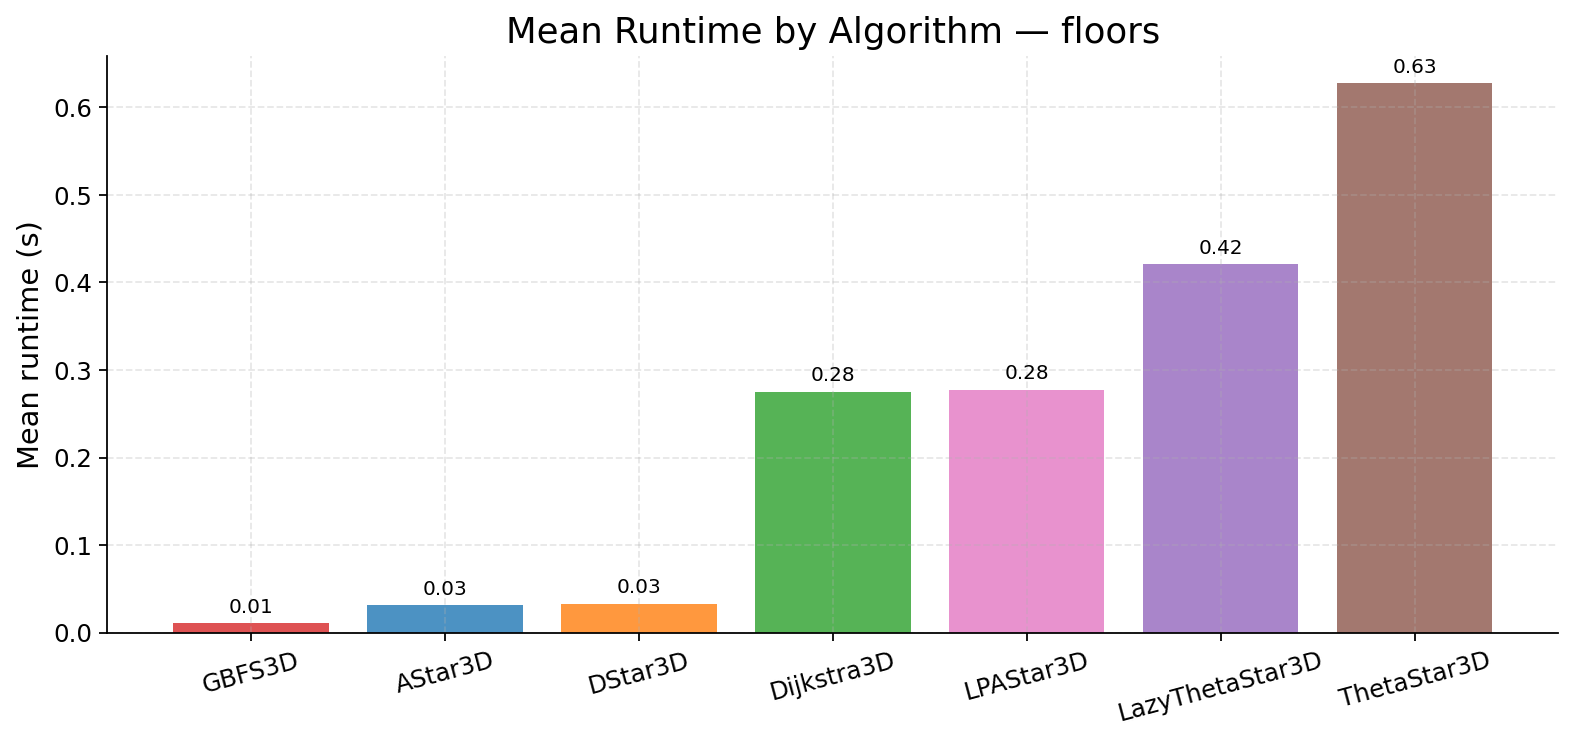

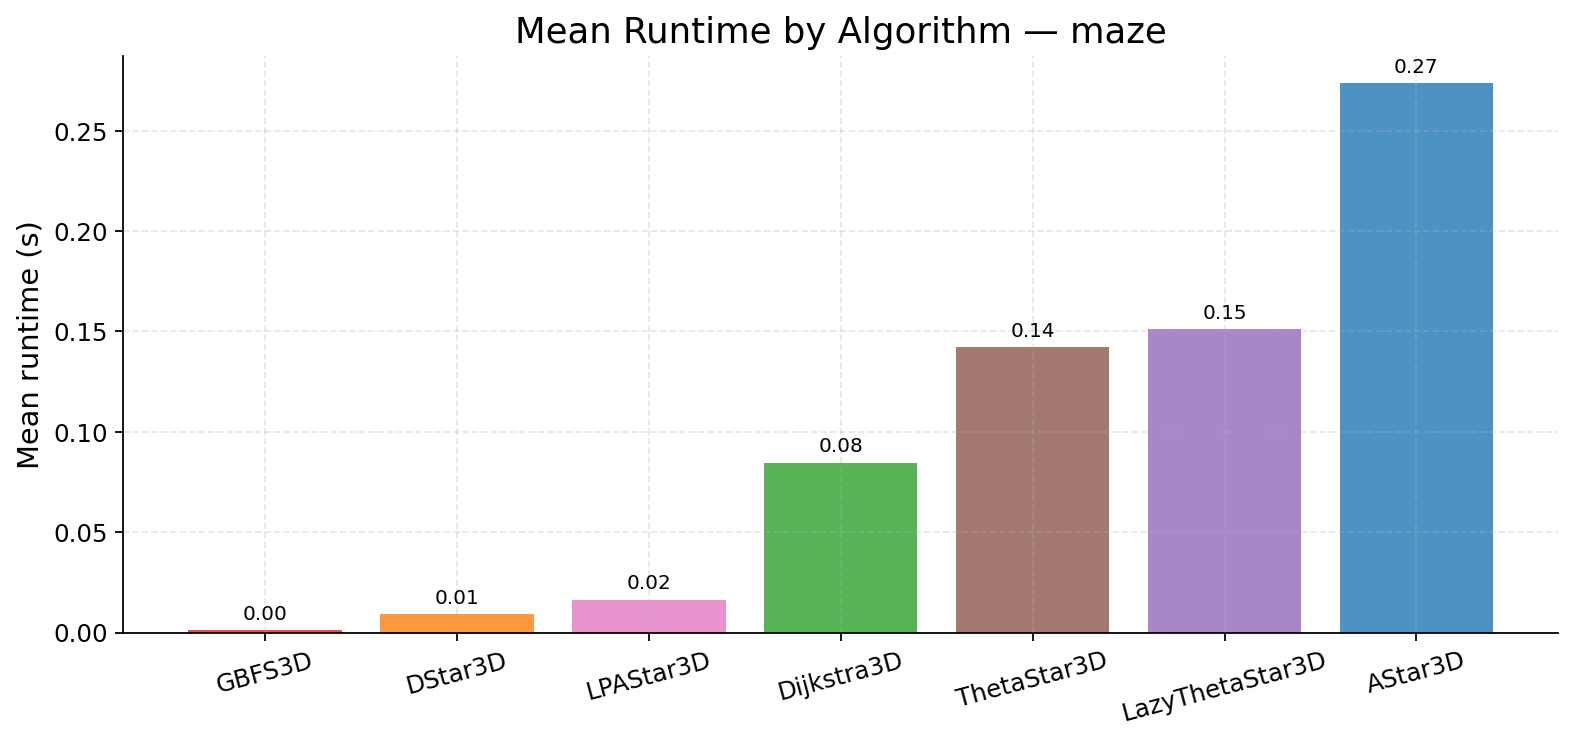

['../output/bar_mean_distance_door.png',
 '../output/bar_mean_distance_empty.png',
 '../output/bar_mean_distance_floors.png',
 '../output/bar_mean_distance_maze.png',
 '../output/bar_mean_runtime_door.png',
 '../output/bar_mean_runtime_empty.png',
 '../output/bar_mean_runtime_floors.png',
 '../output/bar_mean_runtime_maze.png',
 '../output/bar_mean_visited_door.png',
 '../output/bar_mean_visited_empty.png',
 '../output/bar_mean_visited_floors.png',
 '../output/bar_mean_visited_maze.png',
 '../output/box_runtime_by_algorithm.png']

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

csv_path = Path("../3d_pathfinding_results.csv")
out_dir = Path("../output")
out_dir.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(csv_path).rename(columns={
    "Runtime (s)": "runtime_s",
    "Distance": "distance",
    "Visited Nodes": "visited",
})
for col in ["runtime_s","distance","visited"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["runtime_s","distance","visited","Algorithm","Scenario"])

plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 200,
    "figure.figsize": (9,6),
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.3,
    "axes.spines.right": False,
    "axes.spines.top": False,
})

# Create a color map for algorithms
algorithms = df["Algorithm"].unique().tolist()
cmap = plt.get_cmap("tab10")
colors = {alg: cmap(i % 10) for i, alg in enumerate(algorithms)}

def savefig(path_no_ext: Path):
    plt.tight_layout()
    plt.savefig(path_no_ext.with_suffix(".png"), bbox_inches="tight")
    plt.savefig(path_no_ext.with_suffix(".svg"), bbox_inches="tight")
    plt.show()


# ---------- Boxplots ----------
def boxplot_metric(metric, ylabel, title, filename):
    order = df.groupby("Algorithm")[metric].median().sort_values().index.tolist()
    data = [df[df["Algorithm"]==alg][metric].dropna().values for alg in order]
    plt.figure(figsize=(10,5.5))
    bp = plt.boxplot(data, labels=order, showfliers=False, showmeans=True,
                     meanline=True, widths=0.6, patch_artist=True)
    for patch, alg in zip(bp['boxes'], order):
        patch.set_facecolor(colors[alg])
        patch.set_alpha(0.5)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=15, ha="right")
    savefig(out_dir / filename)

# boxplot_metric("distance", "Path length (squares)", "Distance by Algorithm", "box_distance_by_algorithm")
# boxplot_metric("visited", "Visited nodes", "Visited Nodes by Algorithm", "box_visited_by_algorithm")
boxplot_metric("runtime_s", "Runtime (s)", "Runtime by Algorithm", "box_runtime_by_algorithm")

# ---------- Per-scenario bar charts ----------
def autolabel(ax):
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f"{height:.2f}", (p.get_x()+p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=9, xytext=(0,3),
                    textcoords='offset points')

def per_scenario_bars(metric, ylabel, title_prefix, filename_prefix):
    means = (df.groupby(["Scenario","Algorithm"])[metric]
               .mean()
               .reset_index())
    for scen, sub in means.groupby("Scenario"):
        order = sub.sort_values(metric)["Algorithm"].tolist()
        vals = sub.set_index("Algorithm").loc[order][metric].values
        fig, ax = plt.subplots(figsize=(10,4.8))
        bars = ax.bar(order, vals, color=[colors[alg] for alg in order], alpha=0.8)
        ax.set_ylabel(ylabel)
        ax.set_title(f"{title_prefix} — {scen}")
        ax.tick_params(axis='x', labelrotation=15)
        autolabel(ax)
        savefig(out_dir / f"{filename_prefix}_{scen}")

per_scenario_bars("distance", "Mean path length (squares)", "Mean Distance by Algorithm", "bar_mean_distance")
per_scenario_bars("visited", "Mean visited nodes", "Mean Visited Nodes by Algorithm", "bar_mean_visited")
per_scenario_bars("runtime_s", "Mean runtime (s)", "Mean Runtime by Algorithm", "bar_mean_runtime")

sorted([str(p) for p in out_dir.glob("*.png")])
